In [1]:
import numpy as np
np.set_printoptions(precision=4, suppress=True, linewidth=10000)
np.random.seed(0)
import math as math
import matplotlib.pyplot as plt

In [28]:
#defining parameters

popsize = 2000  #10 for the time being
d = [0.2, 0.2]
v = 1
C = 2
L = float('inf')
mut = 0.01
mutsize = 0.1
initmean = [0, 0, 0]
shared = False
generations = 1000

In [29]:
#basic parameters and initialising pop array

v = v / (popsize / 2)  # to make the situation comparable with the assumptions in the numerical stuff
warning = 0  # so far no warnings found that 'trackmatings' below is too long

# initialize the population
# 'sex=0' simply defines that 1st column will sex (where we will use the notation -1 = male, +1 = female)
sex = 0


pop = np.sign(np.random.randn(1, popsize))

# columns 2-3 are shared alleles, 4-5 male alleles, 6-7 female alleles
sa = np.array([1, 2])
ma = np.array([3, 4])
fa = np.array([5, 6])  # these are indices for: shared alleles, male alleles, female alleles
maledeathrate = d[0]
femaledeathrate = d[1]

trackmatings = min(20, popsize)# number of matings we track for a female - if she's mated with >20 males and the first 20 are all sperm depleted this is a potential problem, in that case please increase this value

# pop[sa[0]:fa[1], :] = np.random.normal(6, popsize)

# pop[1:6, :] = np.random.normal(0, 1, size=(6, popsize))
pop = np.vstack([pop, np.random.normal(0, 1, size=(6, popsize))])

pop[sa[0:1], :] += initmean[0]
pop[ma[0:1], :] += initmean[1]
pop[fa[0:1], :] += initmean[2]


if shared:
        mel = np.concatenate((sa, ma))  # mel stands for male-expressed loci
        fel = np.concatenate((sa, fa))  # fel stands for female-expressed loci
else:
        mel = ma
        fel = fa

# run one mating season
# figure out when each individual emerges (according to their timing phenotype)


t_for_axis = np.arange(0, generations, 10)

In [10]:
def emergencesample(T):
    p = np.random.rand(*T.shape)
    sample = T + np.log(p / (1 - p))
    return sample

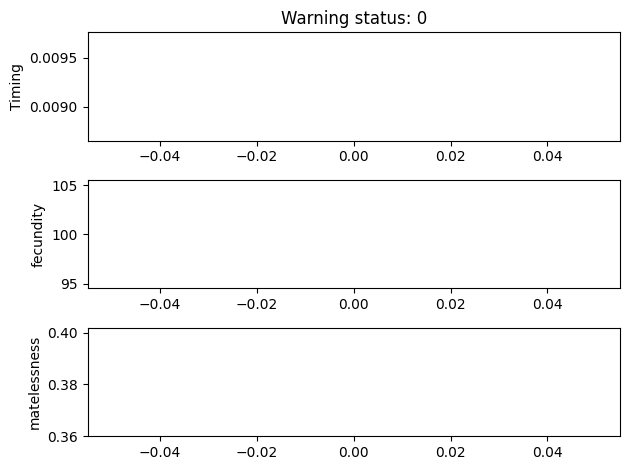

generation 1


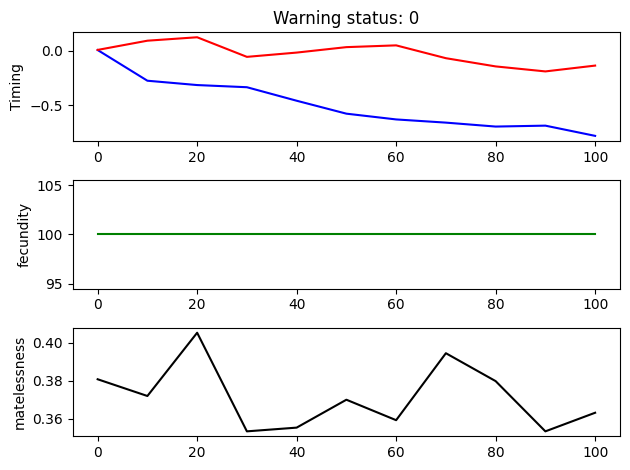

generation 101


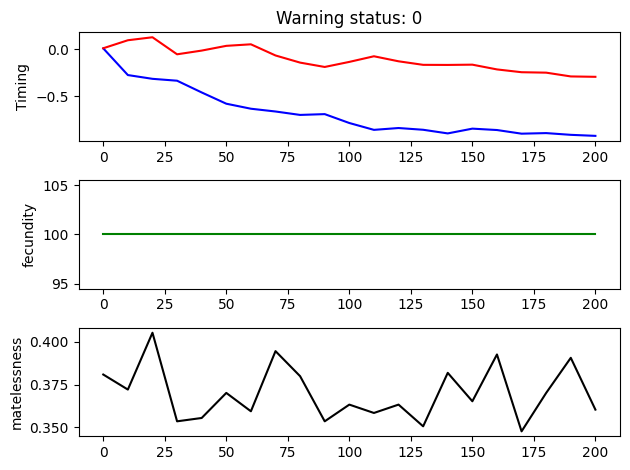

generation 201


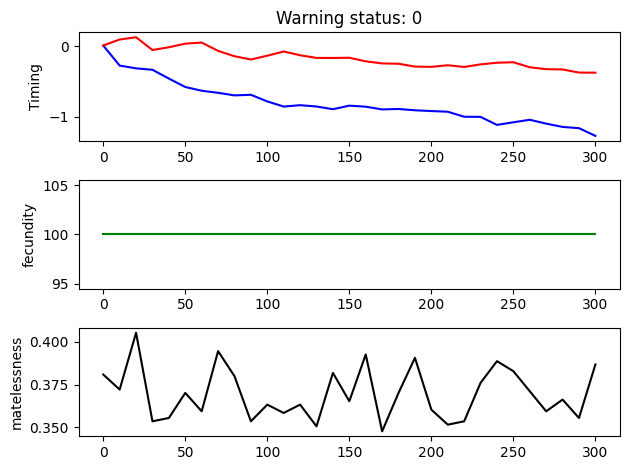

generation 301


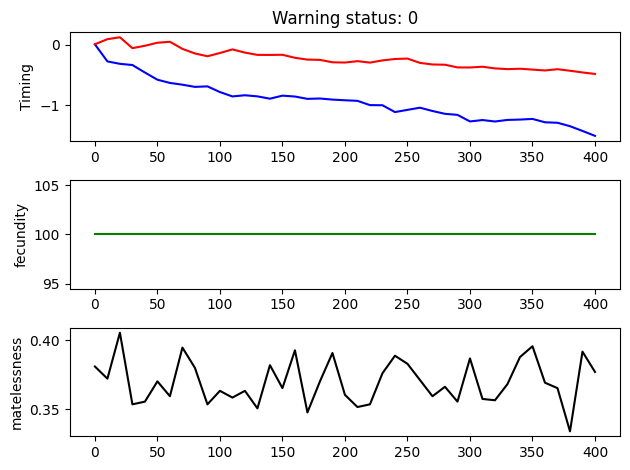

generation 401


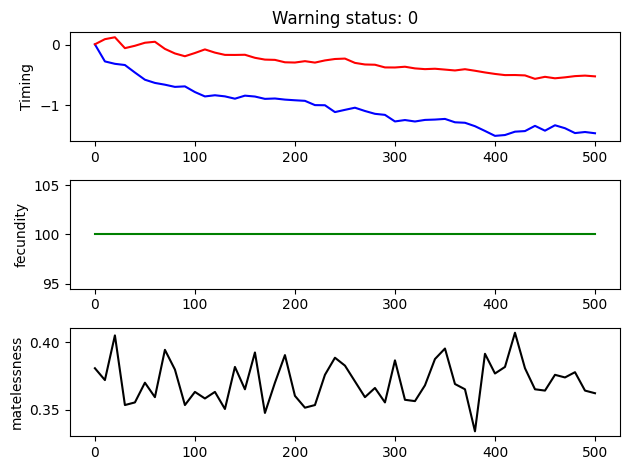

generation 501


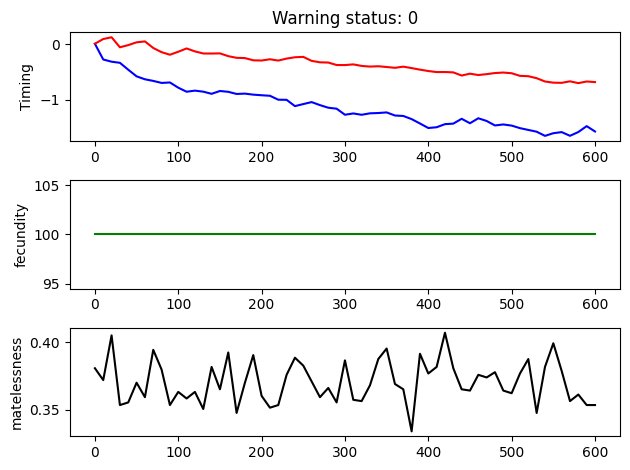

generation 601


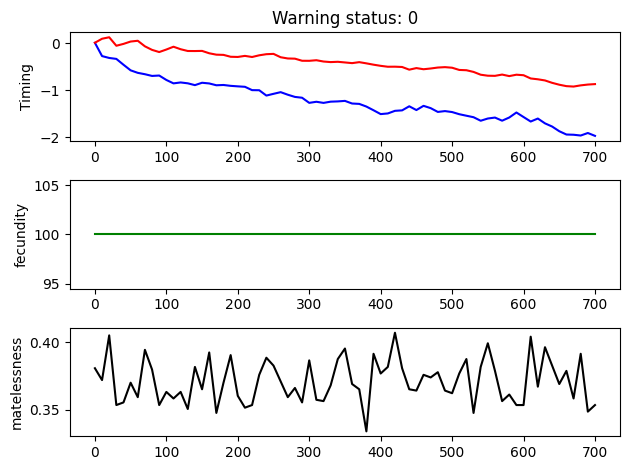

generation 701


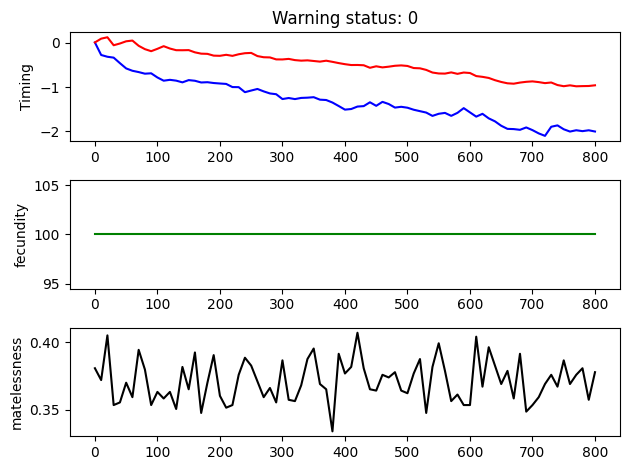

generation 801


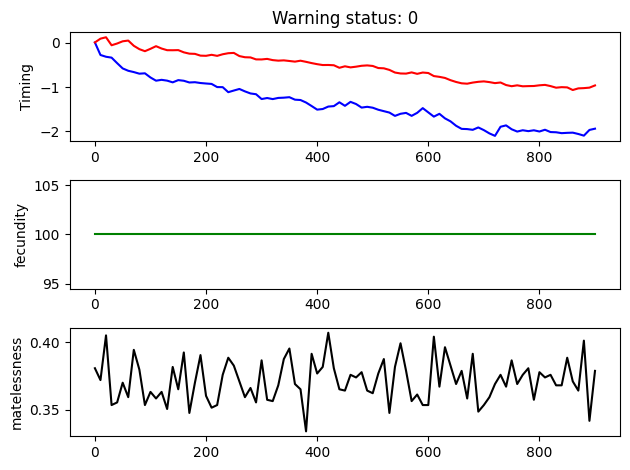

generation 901


In [30]:
# print(pop)

shape = (int((generations - 1)/ 10 + 1), 4)
data = np.full(shape, np.nan)


for k in range(1, generations + 1):

    phenotype = (pop[sex, :] < 0) * np.mean(pop[mel, :], axis = 0) + (pop[sex, :] > 0) * np.mean(pop[fel, :], axis = 0)
    emergencetime = emergencesample(phenotype)

    deathtime = emergencetime + ((pop[sex, :] < 0) * np.random.exponential(scale=1/maledeathrate, size=popsize) +
                                  (pop[sex, :] > 0) * np.random.exponential(scale=1/femaledeathrate, size=popsize))
    

    f = np.where(pop[sex, :] > 0)[0]
    m = np.where(pop[sex, :] < 0)[0]


    T_encounter = np.full((trackmatings, popsize), np.nan)
    who_encounter = np.full((trackmatings, popsize), np.nan)
    

    for i in range(len(f)):
        t_encounter = np.maximum(emergencetime[f[i]], emergencetime) + np.random.exponential(scale=1/v, size=popsize)


        t_encounter[pop[sex, :] > 0] = np.nan
        t_encounter[t_encounter > deathtime[f[i]]] = np.nan
        t_encounter[(t_encounter > deathtime) & (pop[sex, :] < 0)] = np.nan

        sorted_indices = np.argsort(t_encounter)
        sorted_t_encounter = t_encounter[sorted_indices]
        sorted_whichmale = sorted_indices[:trackmatings]
        T_encounter[:trackmatings, f[i]] = sorted_t_encounter[:trackmatings]
        who_encounter[:trackmatings, f[i]] = sorted_whichmale[:trackmatings]


    # print(T_encounter)
    # print(who_encounter)

    flag = np.where(~np.isnan(T_encounter[-1, :]))[0]

    matecount = np.zeros(popsize)
    mateidentity = np.full(popsize, np.nan)
    relativefecundity = np.zeros(popsize)

    while np.any(~np.isnan(T_encounter[0, :])):
        ind = np.nanargmin(T_encounter[0, :])
        time = T_encounter[0, ind]
        male = int(who_encounter[0, ind])

        if matecount[male] < C:
            T_encounter[:, ind] = np.nan
            matecount[male] += 1
            mateidentity[ind] = male
            relativefecundity[ind] = 400 * np.exp(time / L) / (1 + np.exp(time / L))**2

        else:
            T_encounter[:, ind] = np.concatenate((T_encounter[1:, ind], [np.nan]))
            who_encounter[:, ind] = np.concatenate((who_encounter[1:, ind], [np.nan]))

    # print(relativefecundity, "fecundity")
    # print(mateidentity, "mateidentity")

    if len(flag) > 0 and np.any(relativefecundity[flag] == 0):
        warning = 1

    if np.sum(relativefecundity) == 0:
        print("extinction")
        break
    
    if (k-1)/10==math.floor((k-1)/10):


        mean_male_time = np.mean(np.mean(pop[mel, :][:, pop[sex, :] < 0], axis = 0))
        mean_female_time = np.mean(np.mean(pop[fel, :][:, pop[sex, :] > 0], axis = 0))

        if len(relativefecundity[relativefecundity > 0]):
            mean_fecundity = np.mean(relativefecundity[relativefecundity > 0])
        else:
            mean_fecundity = 0
            print("extinction")
               
        matelessness = 1 - (np.sum(~np.isnan(mateidentity)) / np.sum(pop[sex, :] > 0))


        data[int((k-1)/10), :] = [mean_male_time, mean_female_time, mean_fecundity, matelessness]

        if (k-1)/100== math.floor((k-1)/100):

            plt.figure(1)

            plt.subplot(3, 1, 1)
            plt.plot(t_for_axis, data[:, 0], 'b', t_for_axis, data[:, 1], 'r')
            plt.ylabel('Timing')
            plt.title('Warning status: {}'.format(int(warning)))  # Assuming 'warning' is defined
            plt.subplot(3, 1, 2)
            plt.plot(t_for_axis, data[:, 2], 'g')
            plt.ylabel('fecundity')
            plt.subplot(3, 1, 3)
            plt.plot(t_for_axis, data[:, 3], 'k')
            plt.ylabel('matelessness')

            plt.tight_layout()  # Adjust subplot parameters to give specified padding
            plt.show() 

            print("generation", k)


            
# print(data, "data")
# print("generation over, onto next")

    fecundity_probability = [x / sum(relativefecundity) for x in relativefecundity]
    mother = np.random.choice(popsize, popsize, p=fecundity_probability, replace=True)
    sire = [int(mateidentity[x]) for x in mother]

    offspring = np.sign(np.random.randn(1, popsize))
    offspring = np.vstack([offspring, np.random.normal(0, 1, size=(6, popsize))]) #just randomly assigning. It will be replaced to NaN
    offspring[sa[0]:fa[1]+1, :] = np.nan

    whichallele_egg = np.random.randint(2, size=(3, popsize))
    whichallele_sperm = np.random.randint(2, size=(3, popsize))


    for i in range(popsize):
    # Each female produces one clutch of offspring
    
        # Offspring traits inherited from mother's egg
        offspring[sa[0], i] = pop[sa[0] + whichallele_egg[0, i], mother[i]]
        offspring[ma[0], i] = pop[ma[0] + whichallele_egg[1, i], mother[i]]
        offspring[fa[0], i] = pop[fa[0] + whichallele_egg[2, i], mother[i]]
        
        # Offspring traits inherited from father's sperm
        offspring[sa[1], i] = pop[sa[0] + whichallele_sperm[0, i], sire[i]]
        offspring[ma[1], i] = pop[ma[0] + whichallele_sperm[1, i], sire[i]]
        offspring[fa[1], i] = pop[fa[0] + whichallele_sperm[2, i], sire[i]]


    # print(pop, "pop as in dad")

    pop[sa[0]:fa[1]+1, :] = offspring[sa[0]:fa[1]+1, :] + (np.random.rand(6, popsize) < mut) * mutsize * np.random.randn(1, popsize)

    

# print('----final---')

# print(pop)
# print(relativefecundity)
# print(mateidentity)

Okay, so I have made a plot. Making one that updates itself seems to a bit tricky. Maybe I can hold onto this, compelete teh code first and then get back to this. 

Now, I check offspfring thing. How would i do that - for a fecundity, mate indentity and pop from my -thjn feed it output shouod be same/ 


Divide this further

add it back in piece by piece